In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../../conformal')
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
import pandas as pd
from sklearn import linear_model as lm
from sklearn import kernel_ridge as kr
from conformal_indep import SplitConformal

In [2]:
import jax
import jax.numpy as jnp
import hj_reachability as hj

## HJ Setup

In [3]:
class ExtendedDubinsCar(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        x, y, s, theta = state
        return jnp.array([
            s*jnp.cos(theta),
            s*jnp.sin(theta),
            0.,
            0.
        ])

    def control_jacobian(self, state, time):
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., 1.]
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [0., 0.],
            [0., 0.]
        ])
    
    def optimal_control_and_disturbance(self, state, time, grad_value):
        """Computes the optimal control and disturbance realized by the HJ PDE Hamiltonian."""
        control_direction = grad_value @ self.control_jacobian(state, time)
#         print(type(control_direction))
        if self.control_mode == "min":
            control_direction = -control_direction
        disturbance_direction = grad_value @ self.disturbance_jacobian(state, time)
        if self.disturbance_mode == "min":
            disturbance_direction = -disturbance_direction
#         print(self.control_space.extreme_point(control_direction))
        return (self.control_space.extreme_point(control_direction),
                self.disturbance_space.extreme_point(disturbance_direction))

In [4]:
def generate_reachable_set_car(u1_low, u1_high, u2_low, u2_high, x0, ts):
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-5., -5., -5., -np.pi]),
                                                                           np.array([5., 5., 5., np.pi])),
                                                               (50, 50, 20, 50),
                                                               periodic_dims=3)
    center = jnp.concatenate((jnp.expand_dims(x0[0]*jnp.ones_like(grid.states[...,0]), axis=4),
                              jnp.expand_dims(x0[1]*jnp.ones_like(grid.states[...,1]), axis=4),
                              jnp.expand_dims(x0[2]*jnp.ones_like(grid.states[...,2]), axis=4),
                              jnp.expand_dims(x0[3]*jnp.ones_like(grid.states[...,3]), axis=4)
                             ), axis=4)
    values = jnp.linalg.norm(grid.states[..., :] - center, axis=-1) - 1
    control_space = hj.sets.Box(
        lo=jnp.array([u1_low, u2_low]),
        hi=jnp.array([u1_high, u2_high])
    )
    disturbance_space = hj.sets.Box(
        lo=jnp.array([-0.2,-0.2]),
        hi=jnp.array([0.2,0.2])
    )
#     control_space = hj.sets.Ball(jnp.zeros(2), 0)
    dynamics = ExtendedDubinsCar(control_space=control_space, disturbance_space=disturbance_space)
    solver_settings = hj.SolverSettings.with_accuracy("low",
                                                  hamiltonian_postprocessor=hj.solver.identity)
    time = 0.
    target_time = ts
    target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)
    return grid, target_values, values

In [5]:
def find_nearest(grid, val):
    grid_np = np.array(grid)
    return (np.abs(grid_np - val)).argmin()

def get_reachable_union(target_values):
    tv_np = np.array(target_values)
    un = np.sum((tv_np <= 0).astype(int), axis=(2,3)) > 0
#     un = tv_np[:,:,15,10] <= 0
    return un

def in_reach(grid, un, x, y):
    x_disc = np.array(grid.states[:,0,0,0])[:,0]
    y_disc = np.array(grid.states[0,:,0,0])[:,1]
    x_pt = find_nearest(x_disc, x)
    y_pt = find_nearest(y_disc, y)
    return un[x_pt, y_pt]

In [6]:
grid, target_values, values = generate_reachable_set_car(-10,10,-0.01,0.01,[0,0,1,0.3],1)

100%|##########|  1.0000/1.0 [00:06<00:00,  6.77s/sim_s]


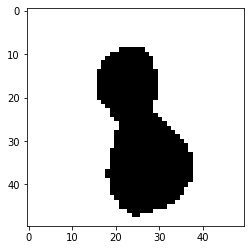

In [7]:
un = get_reachable_union(target_values)
plt.imshow(un, cmap='gray_r')

## Load nuScenes SDK and data

In [8]:
nuScenes_data_path = './v1.0-mini'
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='singapore-queenstown')

In [9]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

In [10]:
with open('../processed/nuScenes_test_mini_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [11]:
ph = 6
log_dir = './models'

In [12]:
# Define ROI in nuScenes Map
# x_min = 773.0
# x_max = 1100.0
# y_min = 1231.0
# y_max = 1510.0

In [13]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

## Feature CSV

In [14]:
train_veh = pd.read_csv('train_100_veh.csv', index_col=[0])
calib_veh = pd.read_csv('train_mini_veh_u_id.csv', index_col=[0])
test_veh = pd.read_csv('test_mini_veh_u_id.csv', index_col=[0])

In [15]:
# prepare train
drop_col = ['log_norm_u_diff', 'scene_num', 'timestep', 'abs_u1_diff', 'abs_u2_diff', 'out_ml_u1', 'out_ml_u2']
for drop_name in ['max_norm', 'cov1_agg', 'cov2_agg', 'mean1_agg', 'mean2_agg']:
    drop_col.extend([f'{drop_name}_{i}' for i in range(1, 6)])
X_init_train = train_veh.loc[:,~train_veh.columns.isin(drop_col)].reset_index(drop=True)
Y_init_train1 = train_veh['abs_u1_diff']
Y_init_train2 = train_veh['abs_u2_diff']

In [16]:
# prepare calibration
drop_col = ['log_norm_u_diff', 'scene_num', 'timestep', 'abs_u1_diff', 'abs_u2_diff', 'out_ml_u1', 'out_ml_u2']
for drop_name in ['max_norm', 'cov1_agg', 'cov2_agg', 'mean1_agg', 'mean2_agg']:
    drop_col.extend([f'{drop_name}_{i}' for i in range(1, 6)])
X_init_calib = calib_veh.loc[:,~calib_veh.columns.isin(drop_col)].reset_index(drop=True)
Y_init_calib1 = calib_veh['abs_u1_diff']
Y_init_calib2 = calib_veh['abs_u2_diff']

In [17]:
get_model = lambda Xs, Ys: kr.KernelRidge(kernel="polynomial").fit(Xs, Ys)

# initialize conformal for u1
candidate_ys_u1 = np.linspace(np.min(Y_init_train1), np.max(Y_init_train1), num=100)
sc1 = SplitConformal(X_init_train, Y_init_train1, X_init_calib, Y_init_calib1, candidate_ys_u1, get_model)

# initialize conformal for u2
candidate_ys_u2 = np.linspace(np.min(Y_init_train2), np.max(Y_init_train2), num=100)
sc2 = SplitConformal(X_init_train, Y_init_train2, X_init_calib, Y_init_calib2, candidate_ys_u1, get_model)

In [18]:
# prepare test
drop_col = ['log_norm_u_diff', 'scene_num', 'timestep', 'abs_u1_diff', 'abs_u2_diff', 'out_ml_u1', 'out_ml_u2']
for drop_name in ['max_norm', 'cov1_agg', 'cov2_agg', 'mean1_agg', 'mean2_agg']:
    drop_col.extend([f'{drop_name}_{i}' for i in range(1, 6)])
#X_init_test = test_veh.loc[:,~calib_veh.columns.isin(drop_col)]
#Y_init_test1 = test_veh['abs_u1_diff']
#Y_init_test2 = test_veh['abs_u2_diff']

In [79]:
focus_id = '8a26f7d33ff04b1a8c8679f8c4a7da91'
focus_veh = test_veh.loc['VEHICLE/'+focus_id]
focus_scene_num = 1
focus_ts = 16
sample = focus_veh[(focus_veh["scene_num"]) == focus_scene_num & (focus_veh["timestep"] == focus_ts)]
sample.columns

Index(['modes', 'max_norm_0', 'max_norm_1', 'max_norm_2', 'max_norm_3',
       'max_norm_4', 'max_norm_5', 'cov1_agg_0', 'cov1_agg_1', 'cov1_agg_2',
       'cov1_agg_3', 'cov1_agg_4', 'cov1_agg_5', 'cov2_agg_0', 'cov2_agg_1',
       'cov2_agg_2', 'cov2_agg_3', 'cov2_agg_4', 'cov2_agg_5', 'mean1_agg_0',
       'mean1_agg_1', 'mean1_agg_2', 'mean1_agg_3', 'mean1_agg_4',
       'mean1_agg_5', 'mean2_agg_0', 'mean2_agg_1', 'mean2_agg_2',
       'mean2_agg_3', 'mean2_agg_4', 'mean2_agg_5', 'prob_sum', 'out_ml_u1',
       'out_ml_u2', 'num_veh_attention', 'num_ped_attention', 'min_pos',
       'avg_pos', 'med_pos', 'min_vel', 'avg_vel', 'med_vel', 'var_u1',
       'var_u2', 'log_norm_u_diff', 'abs_u1_diff', 'abs_u2_diff', 'scene_num',
       'timestep'],
      dtype='object')

In [80]:
u1_hat = sample["out_ml_u1"].iloc[0]
u2_hat = sample["out_ml_u2"].iloc[0]

X_test = sample.drop(drop_col, axis=1).reset_index(drop=True)
assert (X_test.columns == X_init_train.columns).all()

In [81]:
u1_epi = sc1.get_err_bound(np.array(X_test.iloc[0]), alpha=0.2)
u2_epi = sc2.get_err_bound(np.array(X_test.iloc[0]), alpha=0.2)
u1_low, u1_high = u1_hat + u1_epi[0], u1_hat + u1_epi[1]
u2_low, u2_high = u2_hat + u2_epi[0], u2_hat + u2_epi[1]

# Prediction without Map Encoding

In [82]:
model_dir = os.path.join(log_dir, 'models_04_Apr_2022_11_54_58_int_ee') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=12)


Loading from ./models/models_04_Apr_2022_11_54_58_int_ee/model_registrar-12.pt
Loaded!

pred state length 2
pred state length 2


## Crime scene data

In [83]:
scene = eval_scenes[focus_scene_num]
scene.name
x_min, x_max = scene.xlim
y_min, y_max = scene.ylim

In [84]:
timestep = np.array([focus_ts])
ph = 6
vehicle_states = eval_stg_nm.get_features(scene, timestep, ph, min_future_timesteps=ph, num_samples=1)['VEHICLE'][0]

In [85]:
focus_states = vehicle_states.loc['VEHICLE/'+focus_id]
start_x = focus_states[('position_x', 8)]
start_y = focus_states[('position_y', 8)]
start_vel = np.sqrt(focus_states[('velocity_x', 8)] ** 2 + focus_states[('velocity_y', 8)] ** 2)
start_theta = focus_states[('heading_°', 8)]

## Apply HJ

In [86]:
print(u1_low, u1_high, u2_low, u2_high)
grid, target_values, values = generate_reachable_set_car(u1_low,u1_high,u2_low,u2_high,[0,0,start_vel,start_theta],0.5)

0.5399881417404258 2.951830315551983 -0.36562353479442056 0.005429107330434224


In [97]:
print("u1_diff", sample['abs_u1_diff'].iloc[0])
print("u1_bound", u1_epi)
print("u2_diff", sample['abs_u2_diff'].iloc[0])
print("u2_bound", u2_epi)

u1_diff 0.6596088073161486
u1_bound (0.6797839070211493, 3.0916260808327065)
u2_diff -0.8061903474146308
u2_bound (-0.9899529825406974, -0.6189003404158426)


100%|##########|  0.5000/0.5 [00:02<00:00,  5.79s/sim_s]


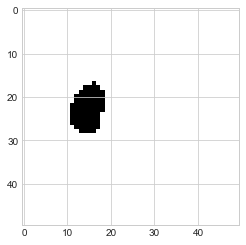

In [87]:
un = get_reachable_union(target_values)
# this visualization is rotated clockwise by 90 degrees because left axis is -x and right axis is +y
plt.imshow(un, cmap='gray_r')

In [88]:
reach_x, reach_y = np.where(un == True)
rotate_matrix = np.array([[np.cos(np.pi/2), np.sin(np.pi/2)], [-np.sin(np.pi/2), np.cos(np.pi/2)]])
reach_real = rotate_matrix @ np.array([reach_x - 25, reach_y - 25])
reach_x_real = reach_real[0] * 0.2 + start_x
reach_y_real = reach_real[1] * 0.2 + start_y

In [89]:
focus_x_history = np.array(focus_states['position_x'], dtype=float)
focus_y_history = np.array(focus_states['position_y'], dtype=float)

In [90]:
# intergate one step
def integrate_dynamics_once(x, u, dt):
    x_dot = np.zeros(4)
    x_dot[0] = x[2] * np.cos(x[3])
    x_dot[1] = x[2] * np.sin(x[3])
    x_dot[2] = u[0]
    x_dot[3] = u[1]
    return x + dt * x_dot
focus_ml_pred_integrated = integrate_dynamics_once(np.array([start_x, start_y, start_vel, start_theta]), np.array([u1_hat, u2_hat]), 0.5)

/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


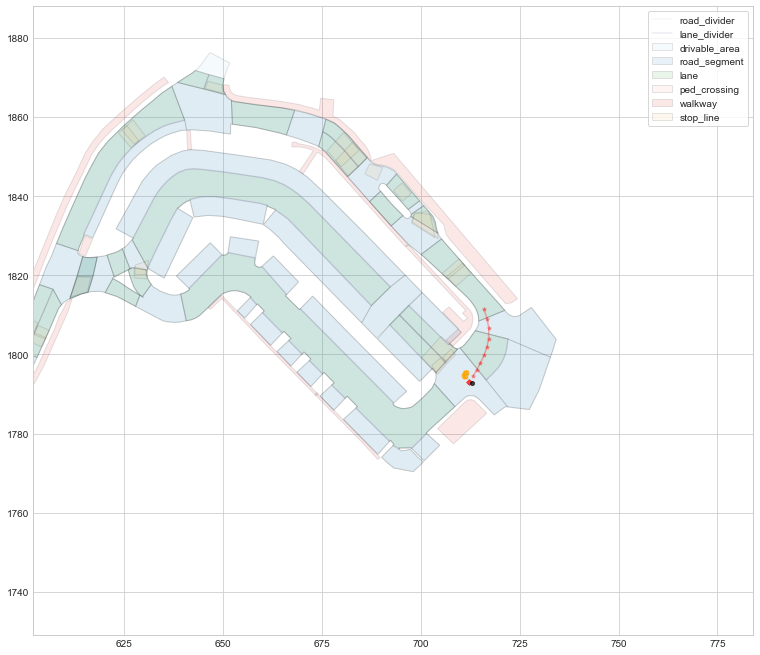

In [91]:
my_patch = (x_min, y_min, x_max, y_max)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)
# plot history
hist_line = ax.plot(focus_x_history + x_min, focus_y_history + y_min, '*-', alpha=0.3, markersize=4, c='r', zorder=605)
c = hist_line[0].get_color()
# plot ground truth
for node in scene.present_nodes(timestep)[timestep[0]]:
    if node.id == focus_id and node.type == "VEHICLE":
        focus_node = node
        break
ax.plot(focus_node.data[:, ('position', 'x')][focus_ts+1] + x_min, focus_node.data[:, ('position', 'y')][focus_ts+1] + y_min, 'D-', alpha=0.7, markersize=4, c='r', zorder=605)
# plot most likely prediction
ax.plot(focus_ml_pred_integrated[0] + x_min, focus_ml_pred_integrated[1] + y_min, 'o-', alpha=0.7, markersize=4, c='k', zorder=605)
# plot reachable set
ax.plot(reach_x_real + x_min, reach_y_real + y_min, '.', alpha=0.7, markersize=1, c='orange', zorder=604)
ax.set_ylim((y_min, y_max))
ax.set_xlim((x_min, x_max))
fig.show()
fig.savefig('plots/reachable_set_one_step.pdf', dpi=300, bbox_inches='tight')

running predict




latent dist torch.Size([2, 1, 25])
mus shape torch.Size([500, 2, 6, 25, 2])
covs shape torch.Size([500, 2, 6, 25, 2, 2])
running predict




latent dist torch.Size([22, 1, 25])
mus shape torch.Size([500, 22, 6, 25, 2])
covs shape torch.Size([500, 22, 6, 25, 2, 2])
running predict




latent dist torch.Size([2, 1, 25])
mus shape torch.Size([1, 2, 6, 25, 2])
covs shape torch.Size([1, 2, 6, 25, 2, 2])
running predict




latent dist torch.Size([22, 1, 25])
mus shape torch.Size([1, 22, 6, 25, 2])
covs shape torch.Size([1, 22, 6, 25, 2, 2])
patch (602.0, 1729.0, 784.0, 1888.0)


/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


0


/home/daly/anaconda3/envs/trajectron++/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


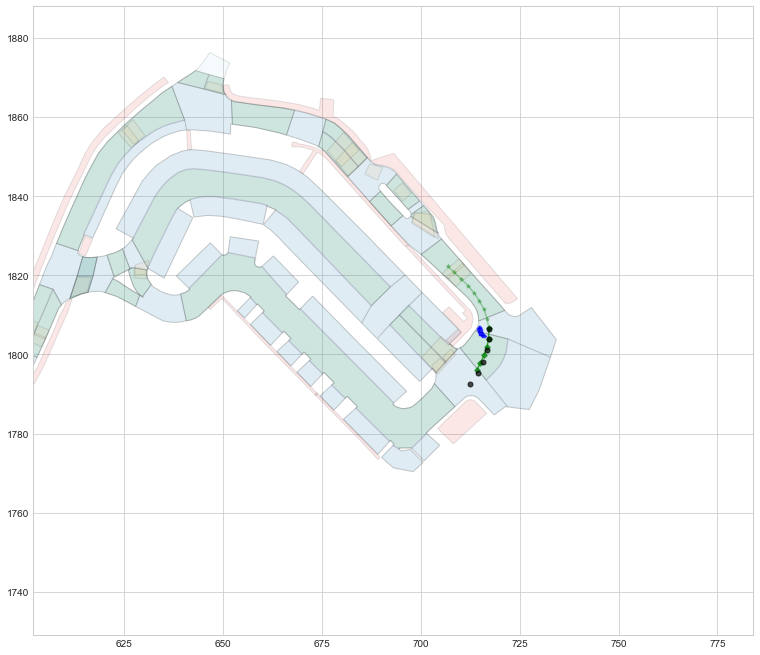

In [49]:
# deprecated plotting code
# dont use

with torch.no_grad():
    timestep = np.array([focus_ts])
    predictions = eval_stg_nm.predict(scene,
                                   timestep-1,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg_nm.predict(scene,
                                      timestep-1,
                                      ph,
                                      num_samples=1,
                                      z_mode=False,
                                        full_dist=True,
                                         all_z_sep=False,
                                      gmm_mode=False)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    print("patch", my_patch)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
    
    #plot_vehicle_pseudo_set_by_id(ax,
    #                  predictions,
    #                  scene.dt,
    #                  "ego",
    #                  max_hl=10,
    #                  ph=ph,
    #                  map=None, x_min=x_min, y_min=y_min)
    
    #ax.plot(scene.nodes[1].data[:, ('position', 'x')] + x_min, scene.nodes[1].data[:, ('position', 'y')] + y_min, 'bo-', alpha=0.3)
    for node in scene.present_nodes(timestep)[timestep[0]]:
        if node.id != "8a26f7d33ff04b1a8c8679f8c4a7da91":
            continue
        if node.type == "PEDESTRIAN":
            markersize = 3
        else:
            markersize = 4
        ts = timestep[0]
        end_idx = ts - node.first_timestep + ph
        print(node.first_timestep)
        
        #hist_line = ax.plot(node.data[:, ('position', 'x')][:ts] + x_min, node.data[:, ('position', 'y')][:ts] + y_min, '*-', alpha=0.3, markersize=markersize, c='g', zorder=605)
        hist_line = ax.plot(focus_x_history + x_min, focus_y_history + y_min, '*-', alpha=0.3, markersize=markersize, c='g', zorder=605)
        c = hist_line[0].get_color()
        ax.plot(node.data[:, ('position', 'x')][ts:end_idx] + x_min, node.data[:, ('position', 'y')][ts:end_idx] + y_min, 'D-', alpha=0.7, markersize=markersize, c='g', zorder=605)
    
    # plot reachable set
    ax.plot(reach_x_real + x_min, reach_y_real + y_min, '.', alpha=0.7, markersize=1, c='b', zorder=604)
    
    #plot_vehicle_mm(ax,
    #                predictions_mm,
    #                scene.dt,
    #                max_hl=10,
    #                ph=ph,
    #                map=None, x_min=x_min, y_min=y_min)
    plot_vehicle_by_id(ax,
                    predictions_mm,
                    scene.dt,
                    "8a26f7d33ff04b1a8c8679f8c4a7da91",
                    max_hl=8,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)
    #ax.set_ylim((1385, 1435))
    #ax.set_xlim((850, 900))
    ax.set_ylim((y_min, y_max))
    ax.set_xlim((x_min, x_max))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    #ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('plots/qual_nuScenes_no_map_pos.pdf', dpi=300, bbox_inches='tight')